In [103]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [104]:
data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [105]:
# Load a pre-trained network 
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [106]:
for param in model.parameters():
    param.requires_grad = False

In [107]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('batchnorm1',nn.BatchNorm1d(4096)),
                          ('fc2', nn.Linear(4096, 512, bias=True)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=0.5)),
                          ('batchnorm2', nn.BatchNorm1d(512)),
                          ('fc3', nn.Linear(512, 256, bias=True)),
                          ('relu3', nn.ReLU()),
                          ('dropout3', nn.Dropout(p=0.5)),
                          ('batchnorm3', nn.BatchNorm1d(256)),
                          ('fc4',nn.Linear(256,10,bias=True)),
                          ('output', nn.Softmax(dim=1))
                          ]))
    
model.classifier = classifier

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [109]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [111]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [112]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [113]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 2.0082 |  Validation Loss: 1.7776 |  Validation Accuracy: 0.7511
Epoch: 1/5 |  Training Loss: 1.7673 |  Validation Loss: 1.6974 |  Validation Accuracy: 0.7956
Epoch: 1/5 |  Training Loss: 1.7111 |  Validation Loss: 1.6567 |  Validation Accuracy: 0.8244
Epoch: 1/5 |  Training Loss: 1.6886 |  Validation Loss: 1.6452 |  Validation Accuracy: 0.8348
Epoch: 1/5 |  Training Loss: 1.6719 |  Validation Loss: 1.6413 |  Validation Accuracy: 0.8278
Epoch: 1/5 |  Training Loss: 1.6815 |  Validation Loss: 1.6344 |  Validation Accuracy: 0.8348
Epoch: 1/5 |  Training Loss: 1.6746 |  Validation Loss: 1.6416 |  Validation Accuracy: 0.8296
Epoch: 1/5 |  Training Loss: 1.6687 |  Validation Loss: 1.6304 |  Validation Accuracy: 0.8389
Epoch: 1/5 |  Training Loss: 1.6553 |  Validation Loss: 1.6165 |  Validation Accuracy: 0.8489
Epoch: 1/5 |  Training Loss: 1.6527 |  Validation Loss: 1.6257 |  Validation Accuracy: 0.8422
Epoch: 1/5 |  Training 

In [114]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [115]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  45.194711208343506
Accuracy achieved by the network on test images is: 86%


In [116]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


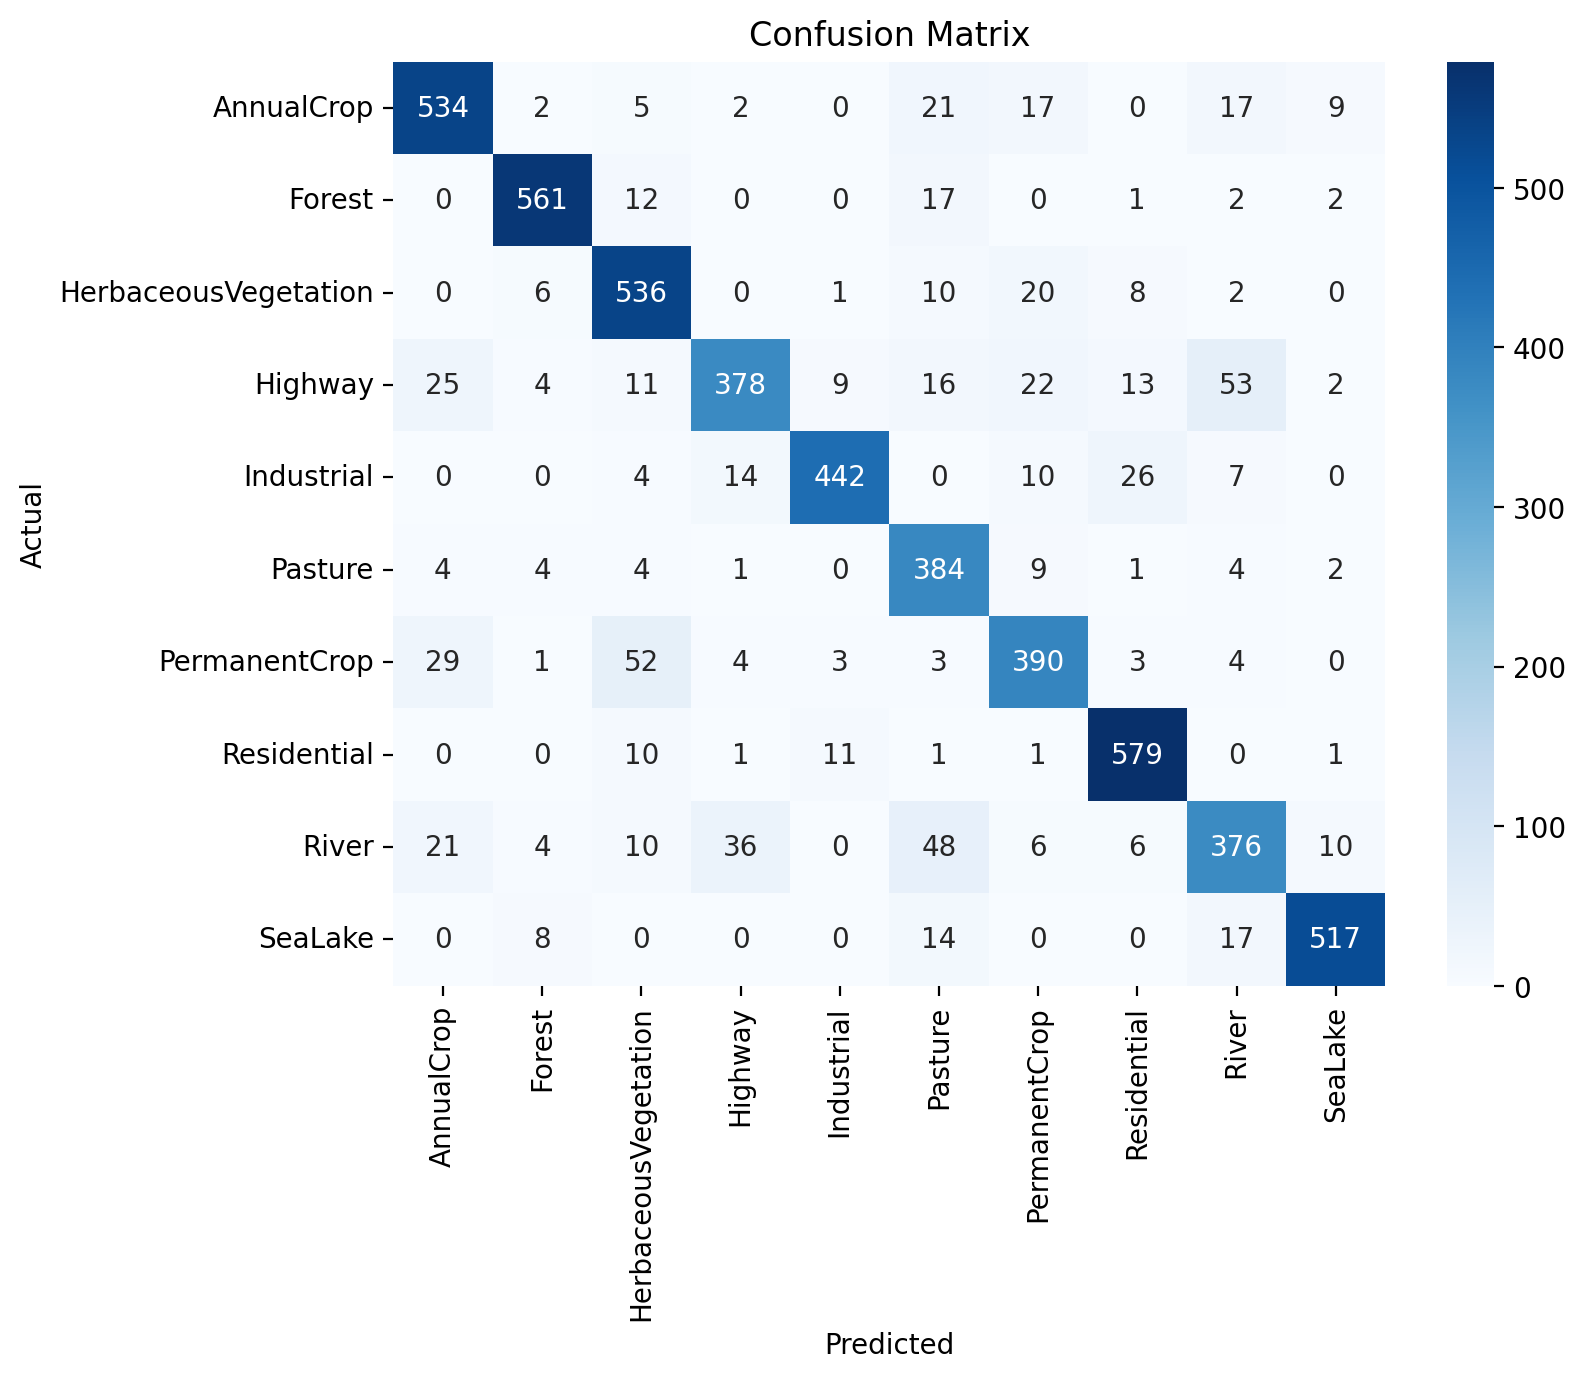

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       607
           1       0.95      0.94      0.95       595
           2       0.83      0.92      0.87       583
           3       0.87      0.71      0.78       533
           4       0.95      0.88      0.91       503
           5       0.75      0.93      0.83       413
           6       0.82      0.80      0.81       489
           7       0.91      0.96      0.93       604
           8       0.78      0.73      0.75       517
           9       0.95      0.93      0.94       556

    accuracy                           0.87      5400
   macro avg       0.87      0.87      0.87      5400
weighted avg       0.87      0.87      0.87      5400



In [117]:
metrics(labels_fp32,predictions_fp32)

In [118]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [119]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:478.94 MB


# Quantization

# FP-16

In [120]:
model_fp16 = copy.deepcopy(model)

In [121]:
model_fp16.half()
model_fp16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [122]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [123]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  26.263304233551025
Accuracy achieved by the network on test images is: 86%


Confusion Matrix:


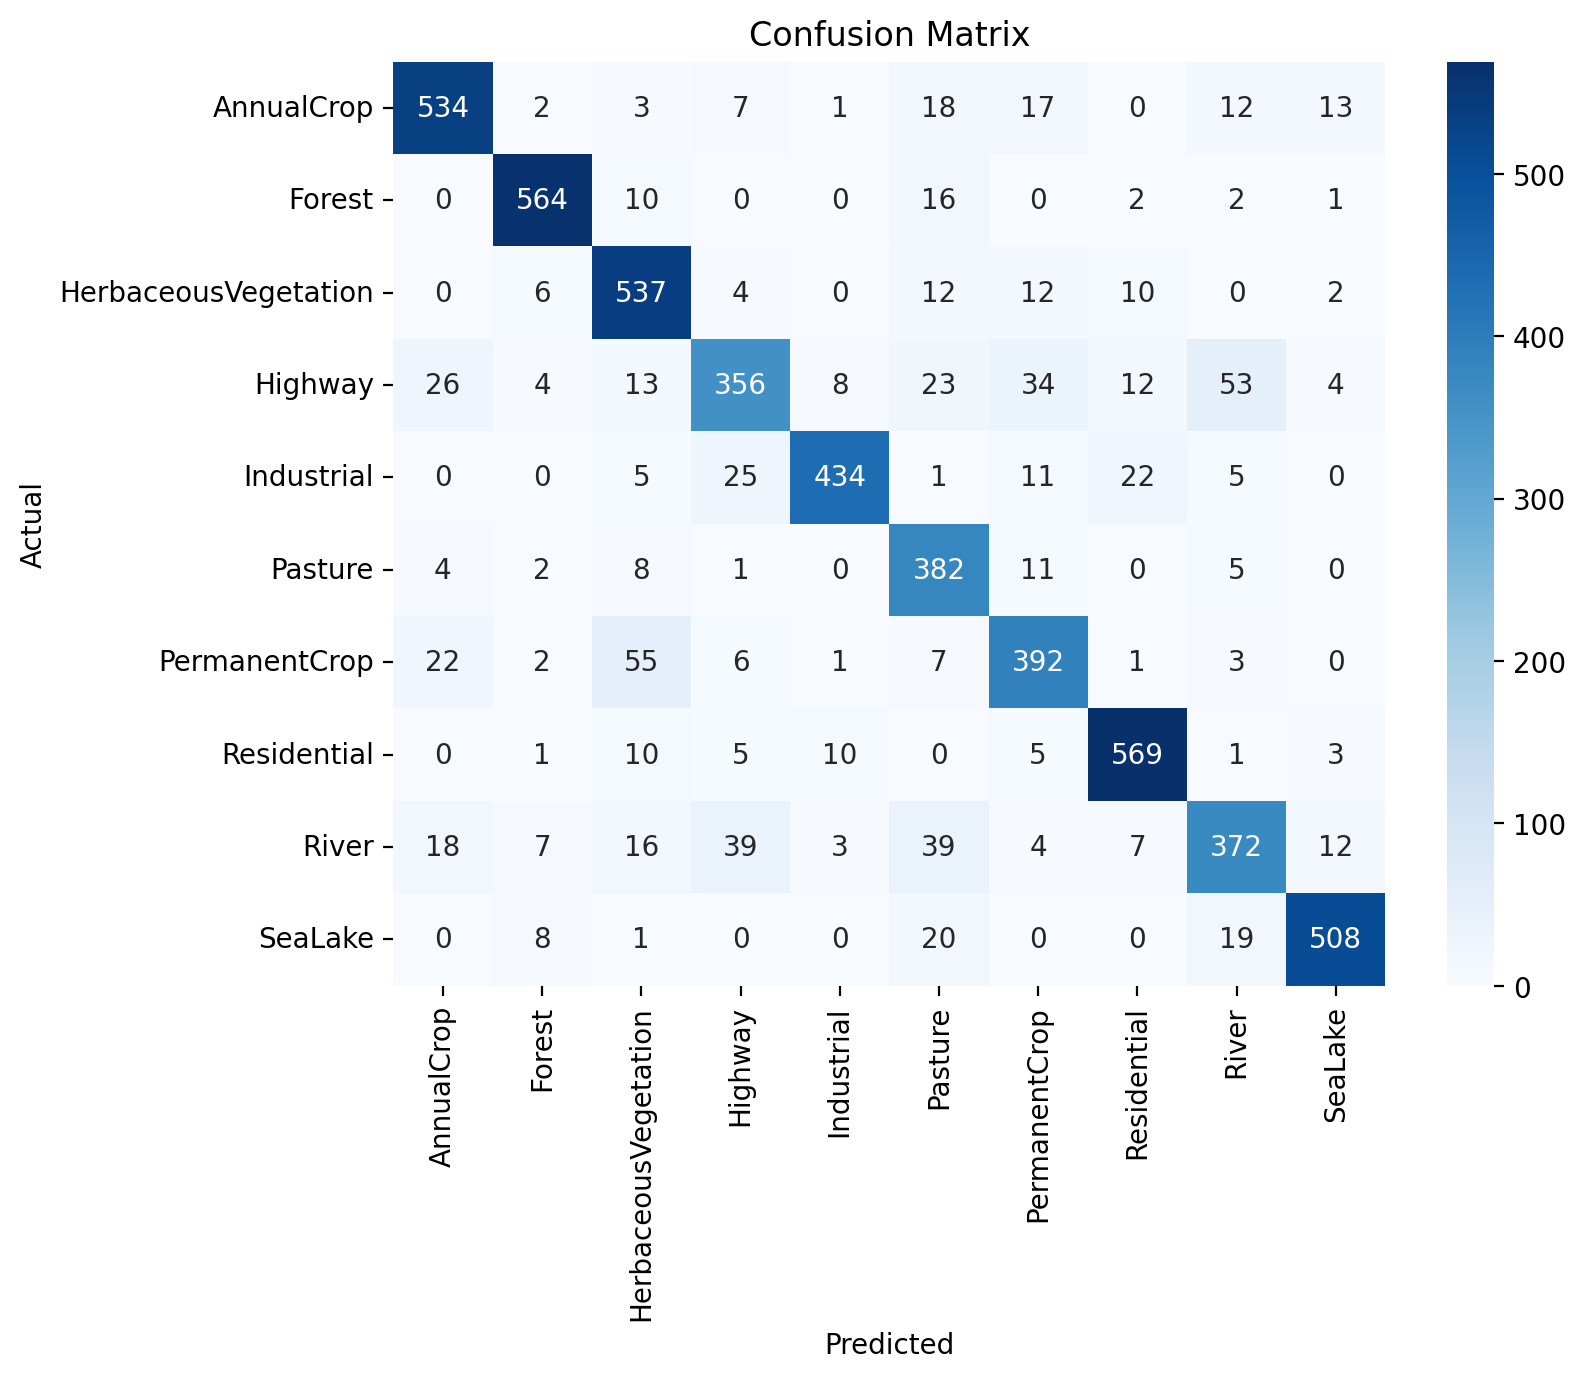

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       607
           1       0.95      0.95      0.95       595
           2       0.82      0.92      0.87       583
           3       0.80      0.67      0.73       533
           4       0.95      0.86      0.90       503
           5       0.74      0.92      0.82       413
           6       0.81      0.80      0.80       489
           7       0.91      0.94      0.93       604
           8       0.79      0.72      0.75       517
           9       0.94      0.91      0.92       556

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.86      0.86      0.86      5400



In [124]:
metrics(labels_fp16,predictions_fp16)

# FP-64

In [125]:
model_64 = copy.deepcopy(model)
model_64.double()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [126]:
weights_64 = model_64.state_dict()
print(weights_64['features.0.weight'].dtype)

torch.float64


In [127]:
model_64.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

model_64.to(device)

In [128]:
def pred_fp64(Model,Testloader): 
    all_labels = [] 
    all_predictions = [] 
    correct = 0 
    total = 0 
    start_time = time() 
    with torch.no_grad(): 
        Model.eval() 
        for images, labels in Testloader: 
            all_labels.extend(labels.numpy()) 
            images, labels = images.to(device), labels.to(device) 
            outputs = Model(images.double())
            _,predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
            predicted_tensor_cpu = predicted.to('cpu') 
            all_predictions.extend(predicted_tensor_cpu.numpy()) 
        end_time = time() 
        print("Time: ",end_time - start_time) 
        print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
        return all_labels,all_predictions

def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [129]:
labels_64,predictions_64 = pred_fp64(model_64,testloader)

Time:  1448.2535800933838
Accuracy achieved by the network on test images is: 85%


 labels,predictions = pred_fp64(model_64,testloader)

Confusion Matrix:


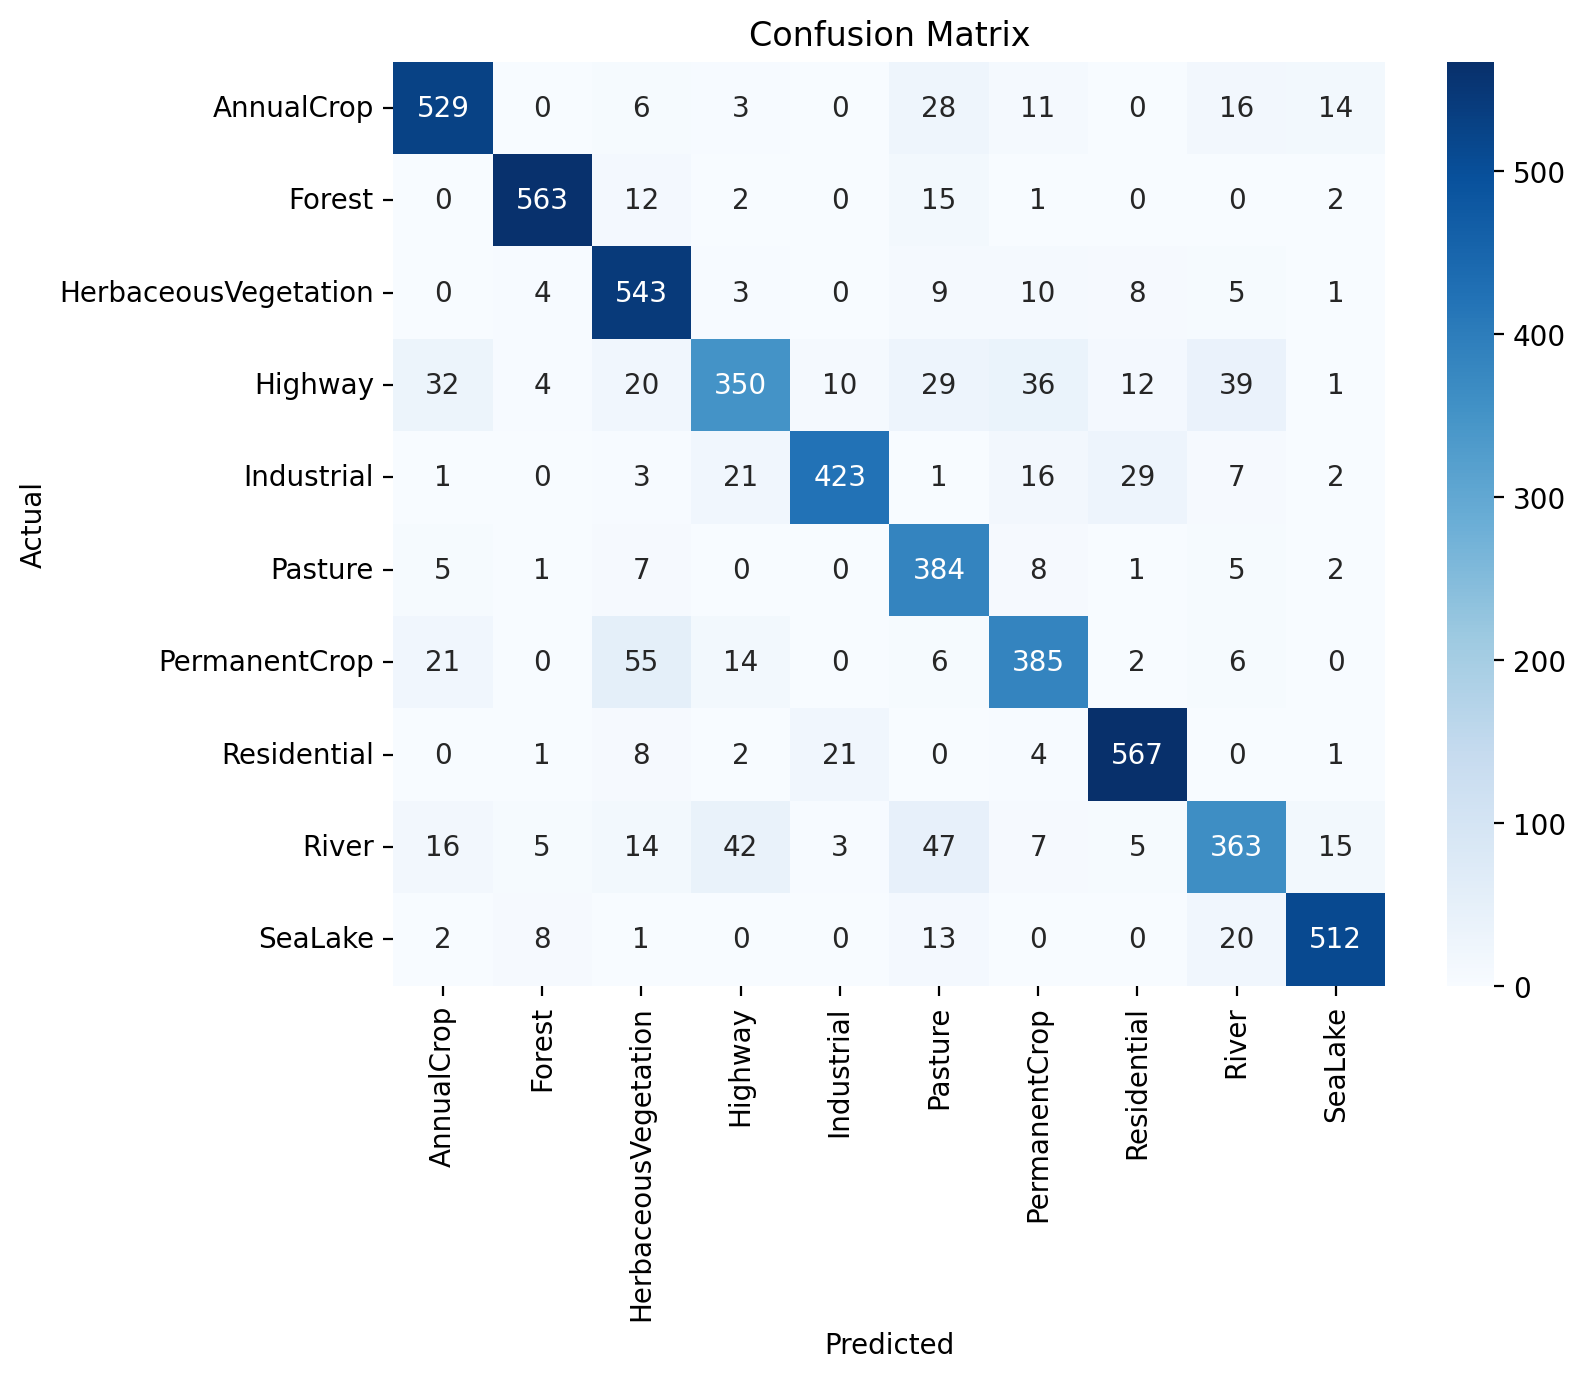

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       607
           1       0.96      0.95      0.95       595
           2       0.81      0.93      0.87       583
           3       0.80      0.66      0.72       533
           4       0.93      0.84      0.88       503
           5       0.72      0.93      0.81       413
           6       0.81      0.79      0.80       489
           7       0.91      0.94      0.92       604
           8       0.79      0.70      0.74       517
           9       0.93      0.92      0.93       556

    accuracy                           0.86      5400
   macro avg       0.85      0.85      0.85      5400
weighted avg       0.86      0.86      0.85      5400



In [130]:
metrics(labels_64,predictions_64)

## INT-8

In [131]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [132]:
model.to('cpu')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [133]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [134]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [135]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [136]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('features_0_input_scale_0', tensor(0.0341)),
             ('features_0_input_zero_point_0', tensor(50)),
             ('classifier_batchnorm1_scale_0', tensor(17.9461)),
             ('classifier_batchnorm1_zero_point_0', tensor(0)),
             ('classifier_batchnorm2_scale_0', tensor(2.6733)),
             ('classifier_batchnorm2_zero_point_0', tensor(0)),
             ('classifier_batchnorm3_scale_0', tensor(0.3765)),
             ('classifier_batchnorm3_zero_point_0', tensor(2)),
             ('features.0.weight',
              tensor([[[[-0.5525,  0.1441,  0.5285],
                        [-0.5825,  0.3543,  0.7627],
                        [-0.6906, -0.0480,  0.4864]],
              
                       [[ 0.1742,  0.0120, -0.0841],
                        [ 0.0420, -0.0721, -0.2582],
                        [ 0.1321, -0.1742, -0.1321]],
              
                       [[ 0.3123, -0.1681, -0.4264],
                        [ 0.4744, -0.0841, -0.4864],
     

In [137]:
model_quantized_static

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.043089691549539566, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07977297902107239, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.06927806884050369, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.12004188448190689, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.1539270281791687, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.15880365669727325, zero_point=0, padding=(1, 1))
    (14): Quant

In [138]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.043089691549539566, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07977297902107239, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.06927806884050369, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.12004188448190689, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.1539270281791687, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.15880365669727325, zero_point=0, padding=(1, 1))
    (14): Quant

In [139]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  672.8346173763275
Accuracy achieved by the network on test images is: 16%


Confusion Matrix:


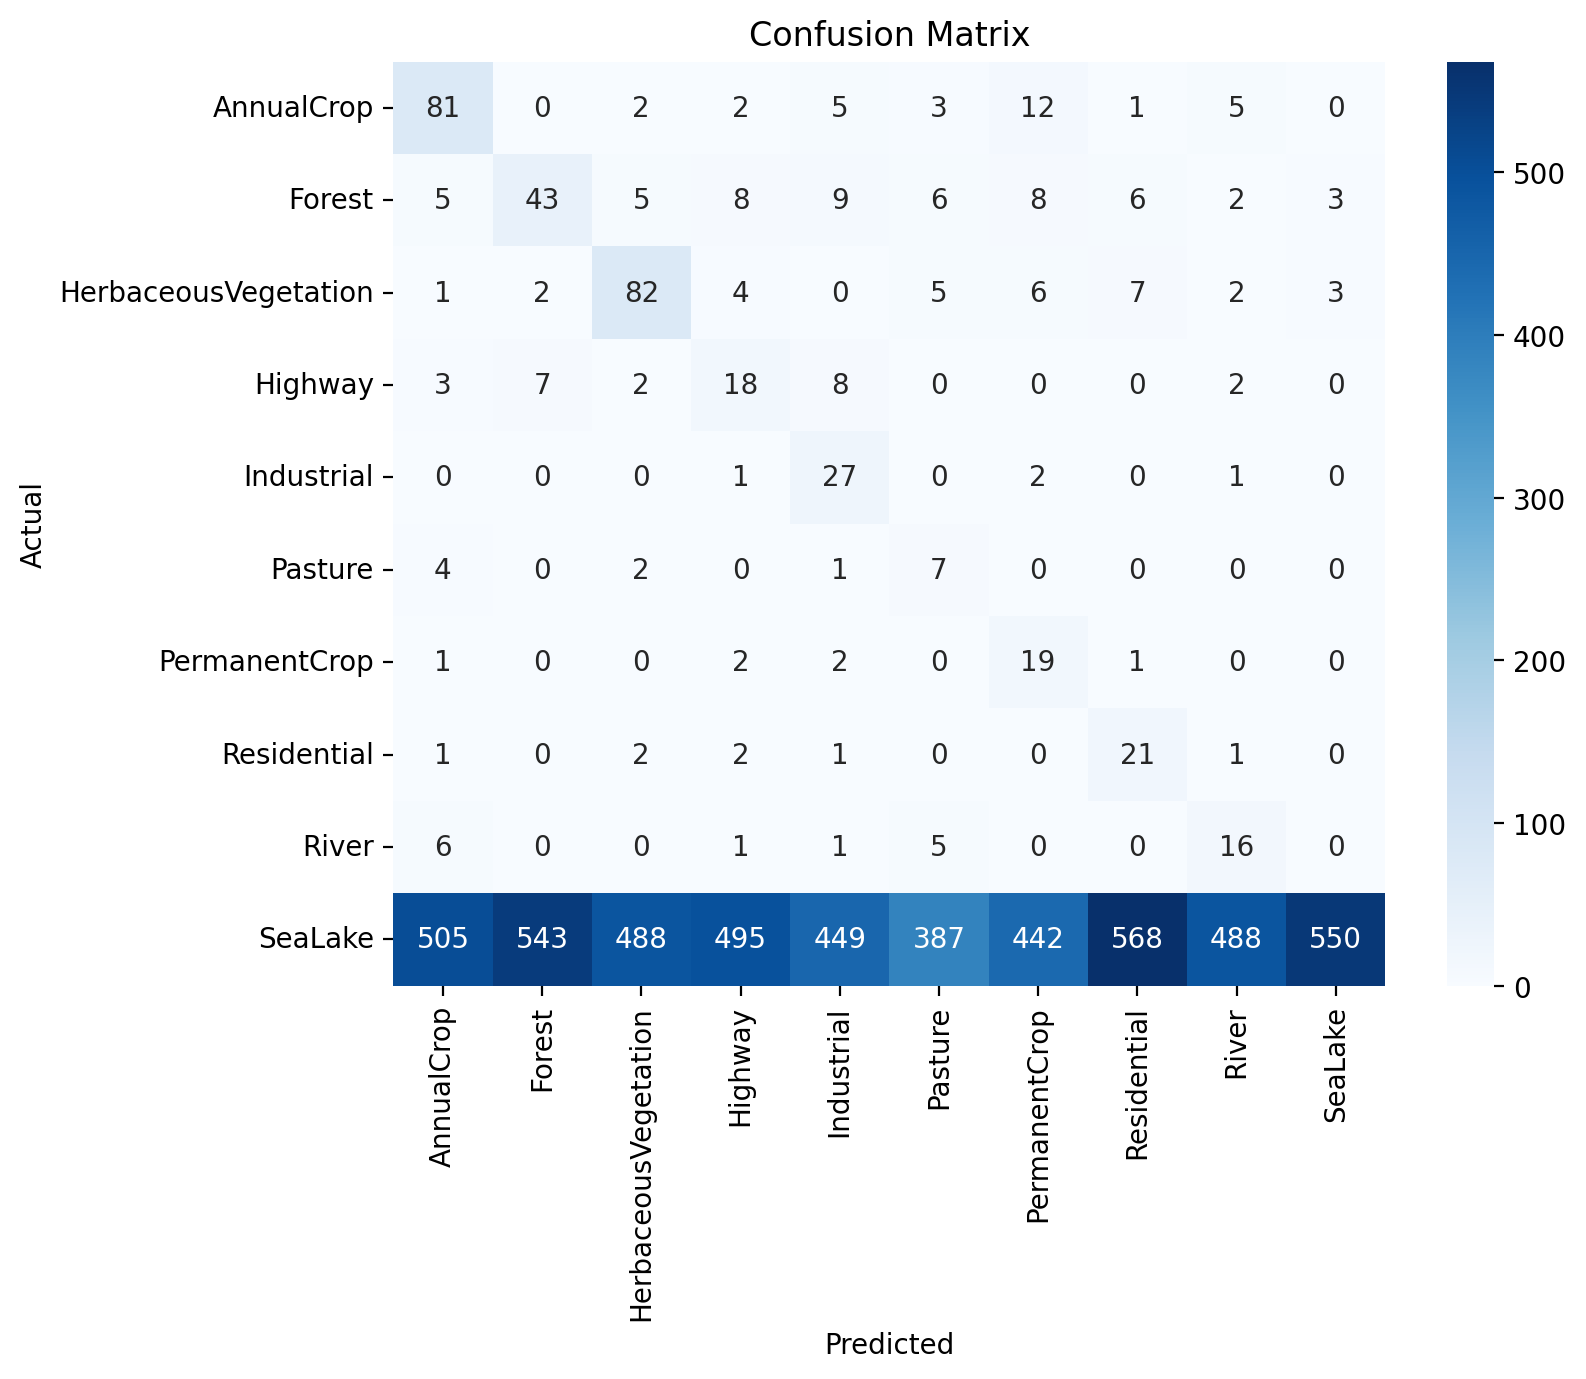

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.73      0.23       111
           1       0.07      0.45      0.12        95
           2       0.14      0.73      0.24       112
           3       0.03      0.45      0.06        40
           4       0.05      0.87      0.10        31
           5       0.02      0.50      0.03        14
           6       0.04      0.76      0.07        25
           7       0.03      0.75      0.07        28
           8       0.03      0.55      0.06        29
           9       0.99      0.11      0.20      4915

    accuracy                           0.16      5400
   macro avg       0.15      0.59      0.12      5400
weighted avg       0.91      0.16      0.20      5400



In [140]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [141]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [142]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [143]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [144]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObse

In [145]:
model_prepared = train(model_prepared,steps,print_every,epochs)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 1.6279 |  Validation Loss: 1.6324 |  Validation Accuracy: 0.8444
Epoch: 1/5 |  Training Loss: 1.6183 |  Validation Loss: 1.7701 |  Validation Accuracy: 0.6944
Epoch: 1/5 |  Training Loss: 1.6352 |  Validation Loss: 1.7492 |  Validation Accuracy: 0.7278
Epoch: 1/5 |  Training Loss: 1.6199 |  Validation Loss: 1.8115 |  Validation Accuracy: 0.6667
Epoch: 1/5 |  Training Loss: 1.6217 |  Validation Loss: 1.8422 |  Validation Accuracy: 0.6359
Epoch: 1/5 |  Training Loss: 1.6281 |  Validation Loss: 2.0357 |  Validation Accuracy: 0.4296
Epoch: 1/5 |  Training Loss: 1.6743 |  Validation Loss: 1.9965 |  Validation Accuracy: 0.4730
Epoch: 1/5 |  Training Loss: 1.6274 |  Validation Loss: 1.7978 |  Validation Accuracy: 0.6807
Epoch: 1/5 |  Training Loss: 1.6303 |  Validation Loss: 1.7601 |  Validation Accuracy: 0.7233
Epoch: 1/5 |  Training Loss: 1.6256 |  Validation Loss: 2.0541 |  Validation Accuracy: 0.4070
Epoch: 1/5 |  Training Loss: 1.6697 |  Validation Loss: 1.94

In [146]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0347]), zero_point=tensor([51], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.7646697759628296, max_val=2.639749050140381)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0060, 0.0066, 0.0084, 0.0021, 0.0085, 0.0023, 0.0071, 0.0021, 0.0033,
                0.0040, 0.0028, 0.0050, 0.0037, 0.0019, 0.0054, 0.0018, 0.0028, 0.0030,
                0.0044, 0.0073, 0.0055, 0.0058, 0.0022, 0.0036, 0.0032, 0.0022, 0.0022,
                0.0030, 0.0034, 0.0034, 0.0020, 0.0024, 0.0051, 0.0067, 0.009

In [147]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [148]:
model_quantized_trained.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09158783406019211, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.12281331419944763, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.13946717977523804, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.18906207382678986, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.28109076619148254, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.3341525197029114, zero_point=0, padding=(1, 1))
    (14): Quanti

In [149]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  679.332807302475
Accuracy achieved by the network on test images is: 64%


Confusion Matrix:


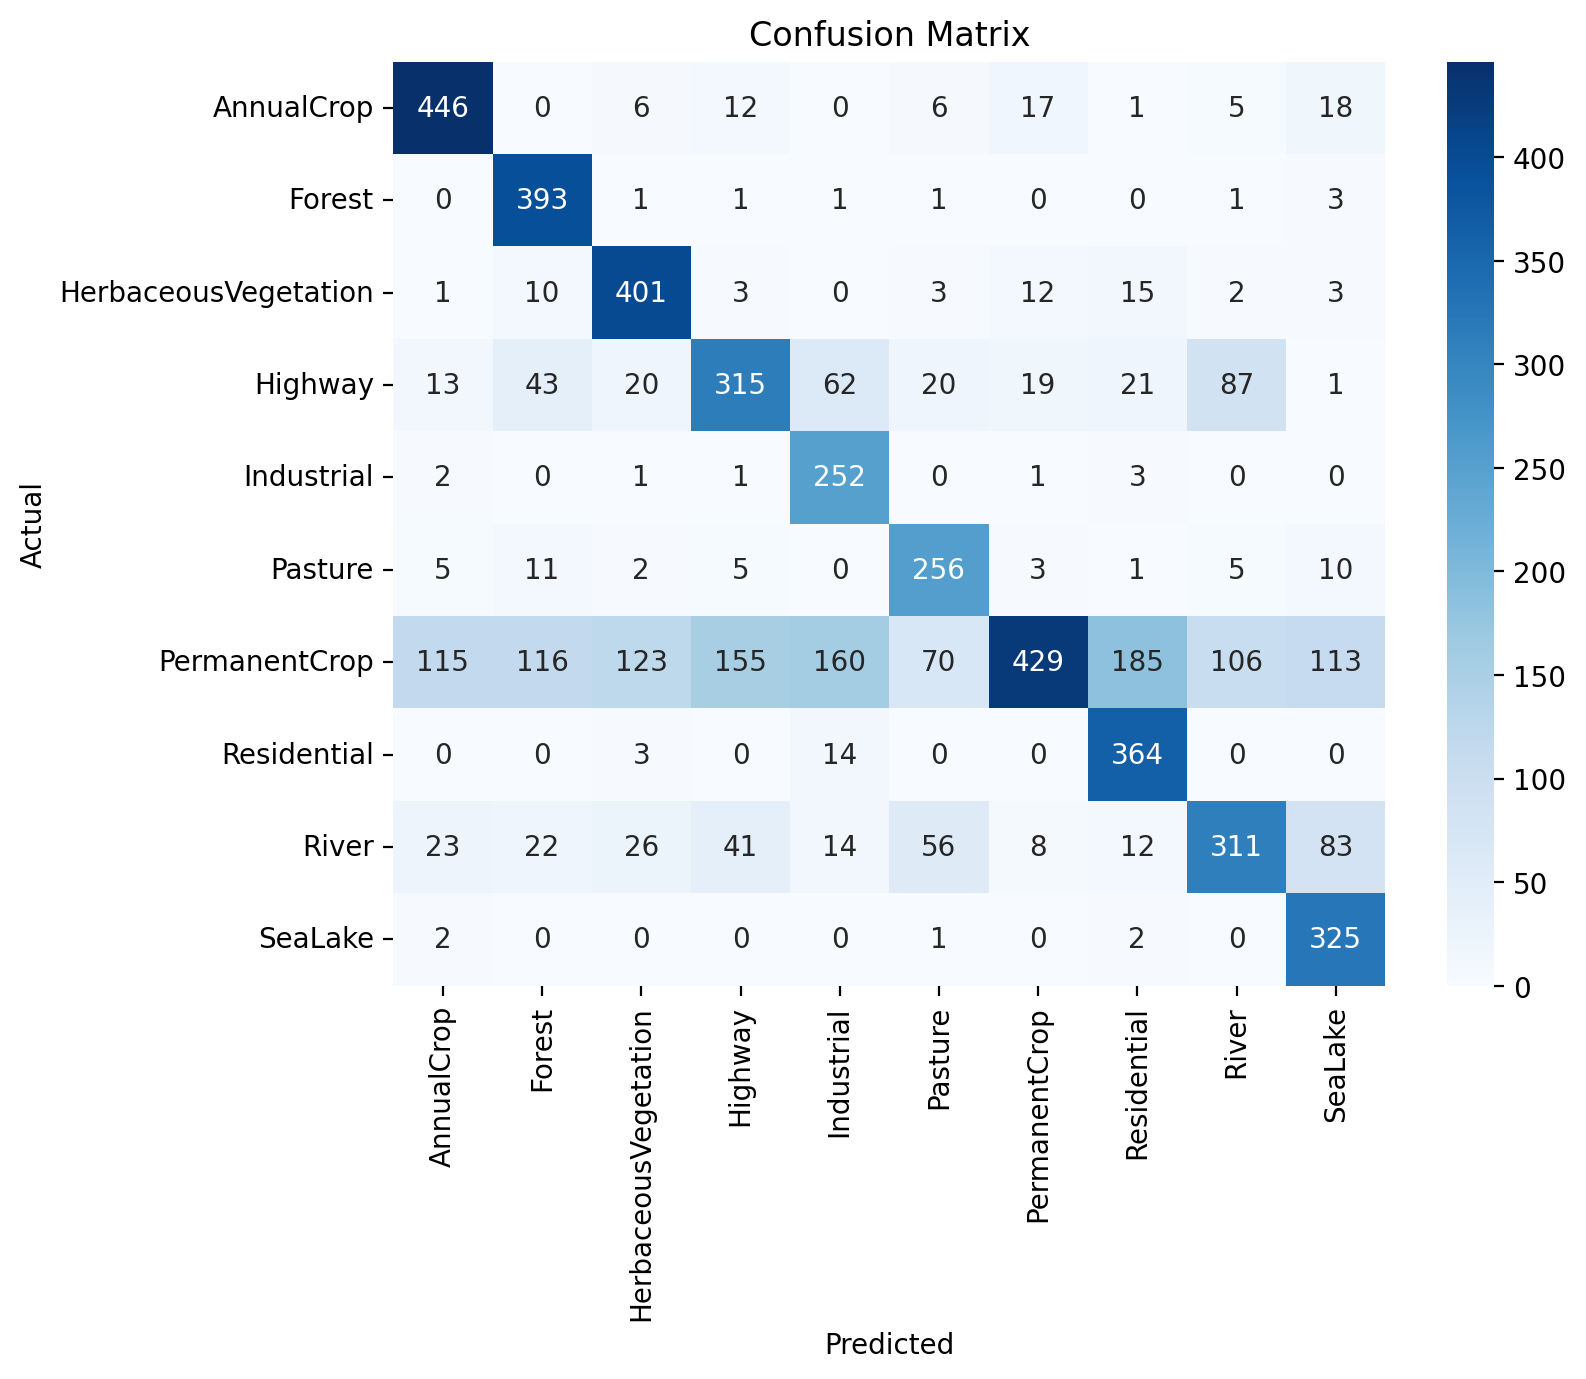

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80       511
           1       0.66      0.98      0.79       401
           2       0.69      0.89      0.78       450
           3       0.59      0.52      0.56       601
           4       0.50      0.97      0.66       260
           5       0.62      0.86      0.72       298
           6       0.88      0.27      0.42      1572
           7       0.60      0.96      0.74       381
           8       0.60      0.52      0.56       596
           9       0.58      0.98      0.73       330

    accuracy                           0.65      5400
   macro avg       0.65      0.78      0.67      5400
weighted avg       0.70      0.65      0.61      5400



In [150]:
metrics(all_predictions_int8,all_labels_int8)

In [151]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)

Size of fp16 model:239.47 MB
Size of PTQ model:119.99 MB
Size of QAT model:119.99 MB
